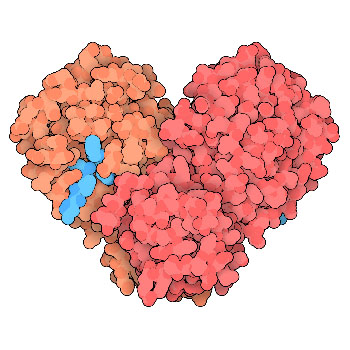

SARS-CoV-2 (2019-nCoV) coronavirus main protease, with inhibitor in turquoise.


# Hello

Notebook is based on this great video, just wrapped into colab:
https://www.youtube.com/watch?v=rBEKZQ22nhs

It was partly released publically also @ https://github.com/vegetablejuiceftw/coronavirus-begone

# Mutation:

Train the network to reconstruct the input smile.
The input is given in the form of two augmented original smile instances and one random smile instance.
The network should start favoring the features that are most present.

But if we give the network 3 random smiles?
- the network should try to figure out the common features of all three smiles.

We can create a small population with that we inbreed for N cycles to generate diverse molecules. 

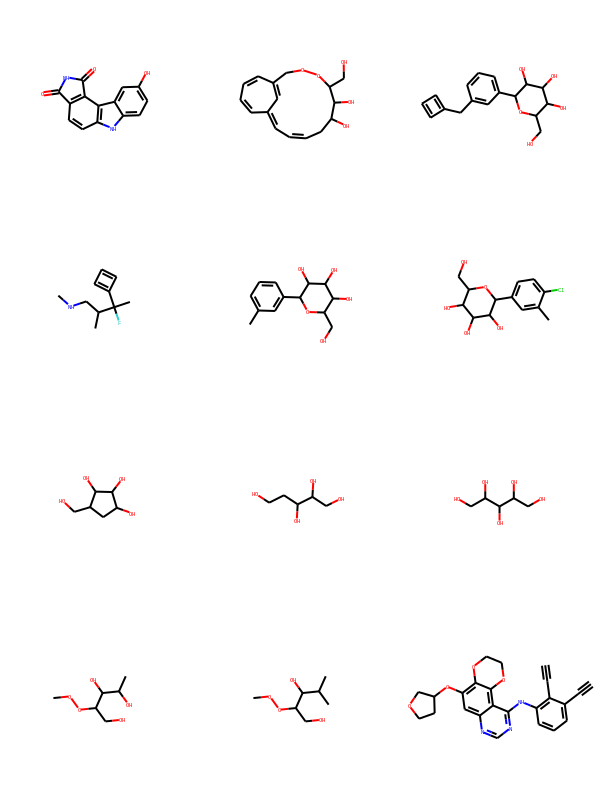


# Dependencies 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Install Autodock Vina and Openbabel

Openbabel translates .smi, .mol2, .pdb and what else into Vina approved .pdbqt  
(pyrx was too much of a hassle to install)

In [4]:
!sudo apt install autodock-vina openbabel pymol

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  apbs libglew2.0 libmaloc1 libopenbabel4v5 pymol-data python-opengl
  python-pmw
Suggested packages:
  autodock autogrid glew-utils libgle3 python-pmw-doc
The following NEW packages will be installed:
  apbs autodock-vina libglew2.0 libmaloc1 libopenbabel4v5 openbabel pymol
  pymol-data python-opengl python-pmw
0 upgraded, 10 newly installed, 0 to remove and 25 not upgraded.
Need to get 8,849 kB of archives.
After this operation, 38.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmaloc1 amd64 0.2-3.1 [48.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 apbs amd64 1.4-1build1 [218 kB]
Get:3 http://archive.ubuntu.com/ubuntu bi

## Install rdkit

In [5]:
# https://iwatobipen.wordpress.com/2018/11/01/run-rdkit-and-deep-learning-on-google-colab-rdkit/
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-03-02 17:00:35--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   189MB/s    in 0.4s    

2020-03-02 17:00:36 (189 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_

## Install LSTM chem

[Dataset used only]

In [6]:
!git clone https://github.com/topazape/LSTM_Chem.git
!mv LSTM_Chem/* .
!pip install bunch

Cloning into 'LSTM_Chem'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 567 (delta 0), reused 1 (delta 0), pack-reused 564
Receiving objects: 100% (567/567), 360.56 MiB | 33.69 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Checking out files: 100% (50/50), done.
  Created wheel for bunch: filename=bunch-1.0.1-cp37-none-any.whl size=7076 sha256=847a648f177275e480cfc71f4ec4b40ca1f775781dfd9f4190e84e42666ef22b
  Stored in directory: /root/.cache/pip/wheels/56/0f/19/fbbf81e5764e6d8b74501c4357a88c14c94466ec777c03734c
Successfully built bunch


## Misc

In [7]:
!pip install tinydb

# Imports

In [8]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.generator import LSTMChemGenerator

from IPython.display import Image, display

import matplotlib.pyplot as plt
from collections import namedtuple
from random import sample, randint, uniform, choice, shuffle

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
RDLogger.DisableLog('rdApp.*')

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

import copy
import numpy as np

from random import randint, shuffle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SkipExecution(Exception):
    def _render_traceback_(self):
        print("Skip execution")

# Coronavirus

## Step 1: download the virus & inhibitor

In [9]:
!wget -nc https://files.rcsb.org/download/6LU7.pdb
!echo "[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC1=CC=CC=C1)NC(=O)C1=C(C)C(O)=CC=C1)[C@@H](C2)C(=O)NC(C)(C)C Nelfinavir" > cov_inhibitor.smi

--2020-03-02 17:02:28--  https://files.rcsb.org/download/6LU7.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.244.12
Connecting to files.rcsb.org (files.rcsb.org)|128.6.244.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘6LU7.pdb’

6LU7.pdb                [ <=>                ] 232.00K  --.-KB/s    in 0.08s   

2020-03-02 17:02:28 (2.93 MB/s) - ‘6LU7.pdb’ saved [237573]



# Step 2: prep

In [10]:
# Source: https://github.com/sarisabban/Notes/blob/master/AutoDock.py
'''
Prepares the receptor by first removing all the water molecules from
the protein's structure, then adds only the polar hydrogens, then
it exports the resulting structure and converts it to a .pdbqt file.
'''
'''
While this seems bit weird, it is as presented in the video tutorial...
It may take quite some time.
'''
!grep ATOM 6LU7.pdb > R.pdb
!pymol R.pdb -c -d "remove resn HOH;h_add acceptors or donors;save temp.pdb"
!babel temp.pdb temp.pdbqt -xh
!grep ATOM temp.pdbqt > cov_receptor.pdbqt
!obabel cov_inhibitor.smi -opdbqt -m --gen3d best -p -xh

 PyMOL(TM) Molecular Graphics System, Version 1.8.4.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Command mode. No graphics front end.
 Detected 2 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "R.pdb" loaded as "R".
PyMOL>remove resn HOH;h_add acceptors or donors;save temp.pdb
 Save: wrote "temp.pdb".
 PyMOL: normal program termination.
1 m

# Molecule mutation explorator

In [39]:
# dataset from LSTM_Chem
class SmilesTokenizer(object):
    def __init__(self, filename):
        atoms = [
            'Li',
            'Na',
            'Al',
            'Si',
            'Cl',
            'Sc',
            'Zn',
            'As',
            'Se',
            'Br',
            'Sn',
            'Te',
            'Cn',
            'H',
            'B',
            'C',
            'N',
            'O',
            'F',
            'P',
            'S',
            'K',
            'V',
            'I',
        ]
        special = [
            '(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's'
        ]
        padding = ['G', 'A', 'E']

        self.table = sorted(atoms, key=len, reverse=True) + special + padding
        self.table_len = len(self.table)

        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(self.table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

        self.smiles = self.load(filename)
        self.tokenized_smiles = [self.tokenize(smi) for smi in tqdm(self.smiles)]
        self.vectorized_smiles = [[self.one_hot_dict[symbol] for symbol in smi] for smi in tqdm(self.tokenized_smiles)]
        self.size = len(self.smiles)
        self.sample_size = 100

    def random(self):
        return self.vectorized_smiles[randint(0, self.size - 1)]

    def sample(self, sample_size):
        self.sample_size = sample_size 

    def __iter__(self):
        return iter(sample(self.vectorized_smiles, self.sample_size))

    def reverse(self, vectorized_smile, join=True):
        index = np.argmax(vectorized_smile, axis=1)
        tokens = [self.table[i] for i in index]
        return "".join(tokens)

    def tokenize(self, smiles):
        N = len(smiles)
        i = 0
        token = []
        while (i < N):
            for j in range(self.table_len):
                symbol = self.table[j]
                if symbol == smiles[i:i + len(symbol)]:
                    token.append(symbol)
                    i += len(symbol)
                    break
        # token.append()
        return token

    def one_hot_encode(self, smile):
        tokenized_smile = self.tokenize(smile) 
        result = [self.one_hot_dict[symbol] for symbol in tokenized_smile]
        return result
    
    # simplef, geo , core
    def load(self, filename, limit=50000):
        smiles = []
        with open(filename) as f:
            for s in tqdm(f):
                s = s.strip()
                if s:
                    smiles.append(s)
                if len(smiles) > limit:
                    break
        return smiles

ds = SmilesTokenizer("./datasets/dataset_cleansed.smi")
# ds = SmilesTokenizer("./datasets/TRPM8_inhibitors_for_fine-tune.smi")
print()
print(ds.smiles[0])
print(ds.tokenized_smiles[0])
print(np.argmax(ds.vectorized_smiles[0], axis=1))
print(ds.reverse(ds.vectorized_smiles[0]))



O=C1Nc2cc(NC(=O)c3c[nH]cc(-c4ccc(C(F)(F)F)cc4)c3=O)ccc2C1=Cc1ccc[nH]1
['O', '=', 'C', '1', 'N', 'c', '2', 'c', 'c', '(', 'N', 'C', '(', '=', 'O', ')', 'c', '3', 'c', '[', 'n', 'H', ']', 'c', 'c', '(', '-', 'c', '4', 'c', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', 'c', '4', ')', 'c', '3', '=', 'O', ')', 'c', 'c', 'c', '2', 'C', '1', '=', 'C', 'c', '1', 'c', 'c', 'c', '[', 'n', 'H', ']', '1']
[17 28 15 32 16 45 33 45 45 24 16 15 24 28 17 25 45 34 45 26 46 13 27 45
 45 24 42 45 35 45 45 45 24 15 24 18 25 24 18 25 18 25 45 45 35 25 45 34
 28 17 25 45 45 45 33 15 32 28 15 45 32 45 45 45 26 46 13 27 32]
O=C1Nc2cc(NC(=O)c3c[nH]cc(-c4ccc(C(F)(F)F)cc4)c3=O)ccc2C1=Cc1ccc[nH]1


In [0]:
class Attention(nn.Module):
    r"""
    https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py
    Applies an attention mechanism on the output features from the decoder.
    .. math::
            \begin{array}{ll}
            x = context*output \\
            attn = exp(x_i) / sum_j exp(x_j) \\
            output = \tanh(w * (attn * context) + b * output)
            \end{array}
    Args:
        dim(int): The number of expected features in the output
    Inputs: output, context
        - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
        - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
    Outputs: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
        - **attn** (batch, output_len, input_len): tensor containing attention weights.
    Attributes:
        linear_out (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
        mask (torch.Tensor, optional): applies a :math:`-inf` to the indices specified in the `Tensor`.
    Examples::
         >>> attention = seq2seq.models.Attention(256)
         >>> context = Variable(torch.randn(5, 3, 256))
         >>> output = Variable(torch.randn(5, 5, 256))
         >>> output, attn = attention(output, context)
    """
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.dim = dim
        if self.dim:
            self.linear_out = nn.Linear(dim * 2, dim)

    def forward(self, output, context, mask = None):
        # https://arxiv.org/abs/1706.03762
        # context & mask is what we attend to
        batch_size, hidden_size, input_size = output.size(0), output.size(2), context.size(1)
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        # matrix by matrix product https://pytorch.org/docs/stable/torch.html#torch.bmm
        attn = torch.bmm(output, context.transpose(1, 2))
        # TODO: scale step missing?
        
        if mask is not None:
            attn.data.masked_fill_(~mask.unsqueeze(1), -float('inf'))

        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)
        if not self.dim:
            return attn

        mix = torch.bmm(attn, context)  # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        combined = torch.cat((mix, output), dim=2)  # concat -> (batch, out_len, 2*dim)

        # output -> (batch, out_len, dim)
        output = torch.tanh(self.linear_out(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)
        return output, attn

class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attention(hidden_size)
        
    def forward(self, previous, hidden_state, encoder_outputs, mask):
        rnn_output, hidden_state = self.gru(previous, hidden_state)
        output, attn = self.attn(rnn_output, encoder_outputs, mask)
        output = self.out(output)
        return output, hidden_state

class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding_size, out_dim=None, num_layers=2, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.batchnorm = nn.BatchNorm1d(embedding_size)
        # Embedding layer that will be shared with Decoder
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, out_dim or hidden_size)   
    
    def forward(self, x, hidden=None):
        x = x.permute(0, 2, 1).contiguous()
        x = self.batchnorm(x)
        x = x.permute(0, 2, 1).contiguous()
        if hidden is None:
            x, hidden = self.gru(x)
        else:
            x, hidden = self.gru(x, hidden)
        # hidden = hidden[:2,:,:] + hidden[2:,:,:]
        x = self.fc(x)
        return x, hidden

In [0]:
# single run
def showTensor(aTensor):
    print(aTensor.shape, aTensor.sum())
    if len(aTensor.shape) > 2:
        aTensor = aTensor[0]

    plt.figure(figsize=(3, 3))
    plt.imshow(aTensor.numpy().T)
    plt.show()


def load(model, path, ignore: list = None):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(path)
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and (not ignore or not any((i in k) for i in ignore))}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(model_dict)

def export_model(model, path):
    torch.save(model.state_dict(), path)

###################################

def mix(target, wrong, ratio):
    target = [(v if randint(0, ratio - 1) else wrong[i % len(wrong)]) for i, v in enumerate(target)]
    return target

def hide(target, ratio):
    target = [(v if randint(0, ratio - 1) else v * 0) for i, v in enumerate(target)]
    return target

def hide_tensor(target, ratio):
    target = target.clone()
    for i in range(target.shape[1]):
        target[:,i,:] *= (randint(0, ratio - 1) != 0) or 0.1
    return target

def mutation(s, n):
  idx = list(range(len(s)))
  shuffle(idx)
  idx = idx[:n]
  mapping = dict((idx[i], idx[i-1]) for i in range(n))
  return [s[mapping.get(x,x)] for x in range(len(s))]

def cleaned_smile(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            return Chem.MolToSmiles(mol)
    except:
        pass

def smile_shuffle(smile, switch=2):
    cleaned_smile =  Chem.MolFromSmiles(smile)
    m1.SetProp("_canonicalRankingNumbers", "True")
    idxs = list(range(0,m1.GetNumAtoms()))
    idxs = mutation(idxs, switch)
    for i,v in enumerate(idxs):
        m1.GetAtomWithIdx(i).SetProp("_canonicalRankingNumber", str(v))
    return Chem.MolToSmiles(m1)

def random_vector(ds, with_original=False):
    index = randint(0, ds.size - 1)
    target = ds.vectorized_smiles[index]
    original = ds.smiles[index]
    tensor = torch.FloatTensor(target).unsqueeze(0)
    if with_original:
        return tensor, original
    return tensor

def best_sub_smile(smile, first=False, draw=False):
    new_smile = list(smile)

    result = []
    for window in range(len(smile), 16, -1):
        for i in range(len(smile) - window):
            snip = smile[i:i+window]
            cleaned_snip = cleaned_smile(snip)
            if cleaned_snip:
                if first:
                    return cleaned_snip

                result.append(snip)
                new_smile[i:i+window] = ["#"] * window

    result = sorted(result, key=len, reverse=True)
    if draw:
        print("".join(new_smile))
        print(*result[:5], sep="\n")
    return "".join(new_smile)   
 

def mask(out, draw=False):
    smile = ds.reverse(out.squeeze(0).detach().numpy())
    if draw: print(smile)
    smile_mask = best_sub_smile(smile, first=False)
    if draw: print(smile_mask)
    out = out.clone()
    if draw: print(out.shape[1], len(smile_mask))
    for i, v in enumerate(smile_mask[:out.shape[1]]):
        out[:,i,:] *= (v == "#" ) or 0.1
    return out

def draw_smiles(smiles):
    try:
        mols = [Chem.MolFromSmiles(cleaned_smile(smi)) for smi in smiles if cleaned_smile(smi)]
        display(Draw.MolsToGridImage(mols))
    except:
        pass

def generate(model, ds, num, smile=None, draw=False):
    model.eval()

    if smile:
        target = torch.FloatTensor(ds.one_hot_encode(smile)).unsqueeze(0) 
    else:
        target = random_vector(ds)

    size = target.shape[1]
    
    if draw: showTensor(target)

    out_none = model(target, target, target)
    out_none = mask(out_none, draw=draw)
    if draw: showTensor(out_none.detach())

    wrong_a = torch.cat([random_vector(ds)] * 3, dim=1)[:,:size,:]
    wrong_b = torch.cat([random_vector(ds)] * 3, dim=1)[:,:size,:]

    targets = [target, out_none, target, out_none, wrong_a, wrong_b]
    
    for i in range(num):
        shuffle(targets)

        genes = [hide_tensor(mol, 8) + torch.randn(mol.shape) * 0.05 for mol in targets[:3]]
        out = model(*genes)
        out = mask(out, draw=draw)
        targets.append(out)
        if draw:
            showTensor(out.detach())

    smiles = set(
        ds.reverse(target.squeeze(0).detach().numpy()) for target in targets
    )
    
    if draw: print(
        *smiles,
        sep='\n',
    )
    smiles = set(best_sub_smile(smile, first=True, draw=draw) for smile in smiles)
    if draw: print(smiles)

    if draw:
        draw_smiles(smiles)

    return smiles 


In [0]:
class LabelSmoothingLossAudio(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target, mask):
        # print(pred.shape, target.shape, mask.shape)
        pred = pred.log_softmax(dim=self.dim)
        # pred: torch.Size([32, 512, 61]) target: torch.Size([32, 512]) Mask:torch.Size([32, 512])
        if mask is not None:
            pred = (mask * pred.T).T
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))




def mutation_trainer(inp, model: nn.Module, loss_function: nn.Module, eval, data_iter=None):
    # target, smile = random_vector(data_iter, with_original=True)
    # targets = [[ds.one_hot_dict[symbol] for symbol in ds.tokenize(smile_shuffle(smile, switch=2))] for swaps in [5, 15, 35]]
    # targets = [torch.FloatTensor(mol).unsqueeze(0) for mol in targets]# + [wrong]
    
    target = torch.FloatTensor(inp).unsqueeze(0)
    wrong = torch.FloatTensor(data_iter.random() if eval else inp).unsqueeze(0)
    wrong = torch.cat([wrong] * 3, dim=1)[:,:len(inp),:]

    w = [v *0 for v in data_iter.random()]
    targets = [hide(inp, 3),  hide(inp, 3),  hide(inp, 3)]#[:2]
    targets = [torch.FloatTensor(mol).unsqueeze(0) for mol in targets] + [wrong]
    
    targets = [mol + torch.randn(mol.shape) * 0.05 for mol in targets][:3]
    shuffle(targets)
    result = model(*targets)
    
    batch_s, time_s, feat_s = result.shape
    flattened_result = result.contiguous().view(batch_s * time_s, -1)
    flattened_targets = target.contiguous().view(batch_s * time_s, -1)
    return loss_function(flattened_result, flattened_targets)

    
def fixer_trainer(inp, model: nn.Module, loss_function: nn.Module, eval, data_iter=None):
    target = torch.FloatTensor(mix(inp, data_iter.random(), 8)).unsqueeze(0)
    result = model(target + torch.randn(target.shape) * 0.1)
    
    batch_s, time_s, feat_s = result.shape
    # "flatten" all logits and targets by putting all subsequences together
    flattened_result = result.contiguous().view(batch_s * time_s, -1)
    flattened_targets = target.contiguous().view(batch_s * time_s, -1)

    return loss_function(flattened_result, flattened_targets)

def train(model, num_epochs, data_iter, eval_iter=None, loss_function=nn.MSELoss(), train_function=mutation_trainer, lr_decay=0.9, lr=0.001, weight_decay=1e-5, repreat=0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.ASGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    print(optimizer)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lr_decay)
    eval_iter = eval_iter or data_iter
    eval_iter = [eval_iter] if type(eval_iter) is not list else eval_iter

    for epoch in range(1, num_epochs+1):
        for e_iter in eval_iter:
            train_acc = evaluate(model, e_iter, train_function, loss_function)  

        print("Starting epoch %d, learning rate is %f" % (epoch, lr_scheduler.get_lr()[0]))        

        for count, batch in (enumerate(data_iter)):
            model.zero_grad()
            model.train()
            optimizer.zero_grad()
            loss = train_function(batch, model, loss_function, False, data_iter=data_iter)
            loss.backward(retain_graph=True)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()

        lr_scheduler.step()   

    for e_iter in eval_iter:
        train_acc = evaluate(model, e_iter, train_function, loss_function)

def evaluate(model, data_iter, train_function=mutation_trainer, loss_function=nn.MSELoss()):
    model.eval()
    total_loss = 0
    size = 0
    with torch.no_grad():
        for batch in (data_iter):
            total_loss += abs(train_function(batch, model, loss_function, True, data_iter).item())
            size += 1
    print(f"  Evaluation[{getattr(data_iter, 'prefix', '')}] - avg_loss: {total_loss/size:.4f} count:{size} Total loss:{total_loss:.4f}")

In [0]:
class MutationNet(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size

        self.encoder = Encoder(hidden_size=hidden_size, embedding_size=embedding_size, out_dim=hidden_size, num_layers=2, dropout=dropout)
        self.decoder = Encoder(hidden_size=hidden_size, embedding_size=hidden_size, out_dim=vocab_size, num_layers=2, dropout=dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2, dropout=dropout, batch_first=True)
        
        self.out = nn.Linear(hidden_size, self.vocab_size)   
        # self.decoder = Decoder(embedding_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=None)
        self.sm = nn.Softmax(dim=2)

    def forward(self, *inputs):

        # 1: combine the inputs
        encoded_inputs, hidden = None, None
        for input_sequence in inputs:
            
            e, hidden = self.encoder(input_sequence, hidden=hidden)
            if encoded_inputs is None:
                encoded_inputs = e
            else:
                encoded_inputs += e
        encoded_inputs /= len(inputs)
        
        # 2: infere the original smile from the combined features
        encoded_inputs, hidden = self.decoder(encoded_inputs, hidden=hidden)
        return self.sm(encoded_inputs)

        # deprecated
        batch_size, out_seq_len, _ = encoded_inputs.shape
        output = torch.zeros(batch_size, out_seq_len, self.vocab_size).to(device) # tensor to store decoder outputs

        current = (encoded_inputs[:,0:1,:]) .clone()
        hidden = hidden[:2,:,:] + hidden[2:,:,:]
        for t in range(out_seq_len):
            
            current, hidden = self.gru(current, hidden)
            output[:,t:(t+1),:] = self.out(current) 

        return self.sm(output)
        

model = MutationNet(ds.table_len, 64, ds.table_len)
load(model, "/content/drive/My Drive/dataset/mutation_model-3.pth", ignore=['out'])

torch.Size([1, 69, 52]) tensor(69.)


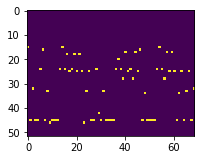

Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2cccc(-(=O)(=O)Nc3cccc(C(=O)O)c3)c2)c1
Cc1cc(###################)cc(-c2cccc(-(=O)(=O)#################)c2)c1
69 69
torch.Size([1, 69, 52]) tensor(39.3000)


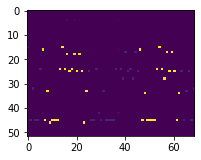

Cc(cc(Nc2nccc(C(F)(F)F)n21cc(=c2cccc(C(=O)(=OcNc3cccc(C(=O)O)c3)c2)(1
Cc(cc(###################1cc(=c2cccc(C(=O)(=Oc#################)c2)(1
69 69
torch.Size([1, 69, 52]) tensor(39.3000)


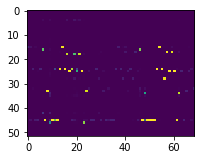

Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2cccc(N(=O)(=O)Nc3cccc(C(=O)O)c3)c2)c1
Cc1cc(###################)cc(-c2cccc(##########################)c2)c1
69 69
torch.Size([1, 69, 52]) tensor(47.4000)


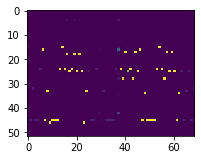

CC(C)(Nc2nccc(C(F)(F)F)n21cc(=c)c1cc(-(=O)(cncNc3cccc(C(=O)C)c3)cNC(1
CC(C)(###################1cc(=c)c1cc(-(=O)(cnc#################)cNC(1
69 69
torch.Size([1, 69, 52]) tensor(39.3000)


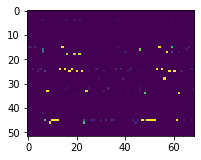

CCCN)(Nc2nccc(C(F)(F)F)n2NCCC)C=NCCC(N(=O)(=O)Nc3cccc(C(=O)O)c3)c4)n1
CCCN)(###################NCCC)C=NCCC(##########################)c4)n1
69 69
torch.Size([1, 69, 52]) tensor(47.4000)


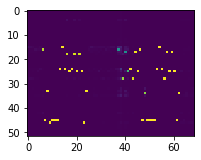

Cc(cc(Nc2nccc(C(F)(F)F)n21cc(=O2cccc(C(=O)(=O)Nc3cccc(C(=O)O)c3)c2)(1
Cc(cc(###################1cc(=O2cccc(C(=O)(=O)#################)c2)(1
69 69
torch.Size([1, 69, 52]) tensor(39.3000)


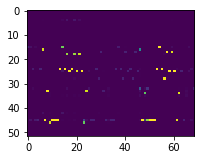

CC(=O)Nc2cccc(C(F)(F)F)c2-c2c4nNcc3c((Cl)ccc23)cc1cccc(C(=O)c)c3c2cnc(
#########################-c2c4nNcc3c((Cl)ccc23)cc1cccc(C(=O)c)c3c2cnc(
69 70
torch.Size([1, 69, 52]) tensor(29.4000)


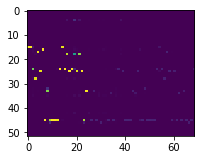

Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2cccc(N(=O)(=O)Nc3cccc(C(=O)O)c3)c2)c1
Cc1cc(###################)cc(-c2cccc(##########################)c2)c1
69 69
torch.Size([1, 69, 52]) tensor(47.4000)


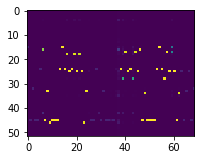

CC(=O)Nc2cccc(C(F)(F)F)c2-c2c4nnnc3cc(()c)c2O)cc1cc(c(C(=O)c)(-cccnc(
#########################-c2c4nnnc3cc(()c)c2O)cc1cc(c(C(=O)c)(-cccnc(
69 69
torch.Size([1, 69, 52]) tensor(29.4000)


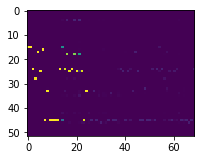

CC(cc(Nc2cccc(C(F)(F)F)n2)cc(-c2cccc(((=O)(=O)Nc3cccc(C(=O)O)(3)c2)c1
CC(cc(###################)cc(-c2cccc(((=O)(=O)Nc3cccc(C(=O)O)(3)c2)c1
69 69
torch.Size([1, 69, 52]) tensor(24.)


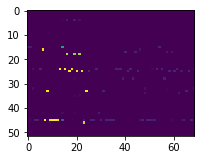

CC(=O)Nc2cccc(C(F)(F)F)c2-c2cnnn-c3cc(Cl)ccc23)cc1CC(=O)Nc1ccc(-c2cnc(
#########################-c2cnnn-c3cc(Cl)ccc23)cc1CC(=O)Nc1ccc(-c2cnc(
69 70
torch.Size([1, 69, 52]) tensor(29.4000)


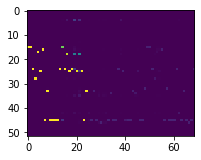

CCCN)(Nc2nccc(C(F)(F)F)n2NCCC)C=NCCC(N(=O)(=O)Nc3cccc(C(=O)O)c3)c4)n1
Cc(cc(Nc2nccc(C(F)(F)F)n21cc(=c2cccc(C(=O)(=OcNc3cccc(C(=O)O)c3)c2)(1
Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2cccc(-(=O)(=O)Nc3cccc(C(=O)O)c3)c2)c1
CC(C)(O)CNC(=O)c1ccc(F)cc1NC(=O)c1nc(C2CC2)cnc1Nc1cncnc1CC(C)(O)CNC(=
CC(cc(Nc2cccc(C(F)(F)F)n2)cc(-c2cccc(((=O)(=O)Nc3cccc(C(=O)O)(3)c2)c1
Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2cccc(N(=O)(=O)Nc3cccc(C(=O)O)c3)c2)c1
Cc(cc(Nc2nccc(C(F)(F)F)n21cc(=O2cccc(C(=O)(=O)Nc3cccc(C(=O)O)c3)c2)(1
CC(=O)Nc2cccc(C(F)(F)F)c2-c2cnnn-c3cc(Cl)ccc23)cc1CC(=O)Nc1ccc(-c2cnc(
CC(C)(Nc2nccc(C(F)(F)F)n21cc(=c)c1cc(-(=O)(cncNc3cccc(C(=O)C)c3)cNC(1
Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2cccc(S(=O)(=O)Nc3cccc(C(=O)O)c3)c2)c1
CC(=O)Nc2cccc(C(F)(F)F)c2-c2c4nnnc3cc(()c)c2O)cc1cc(c(C(=O)c)(-cccnc(
CC(=O)Nc2cccc(C(F)(F)F)c2-c2c4nNcc3c((Cl)ccc23)cc1cccc(C(=O)c)c3c2cnc(
CC(=O)Nc1ccc(-c2cnc(N)nc2-c2c[nH]c3cc(Br)ccc23)cc1CC(=O)Nc1ccc(-c2cnc(
{'O=C(O)c1cccc(N[N+](=O)[O-])c1', 'CNCC(C)(O)Cc1ncncc1Nc1ncc(C2CC2)nc1C(=O)Nc1cc(F)ccc1

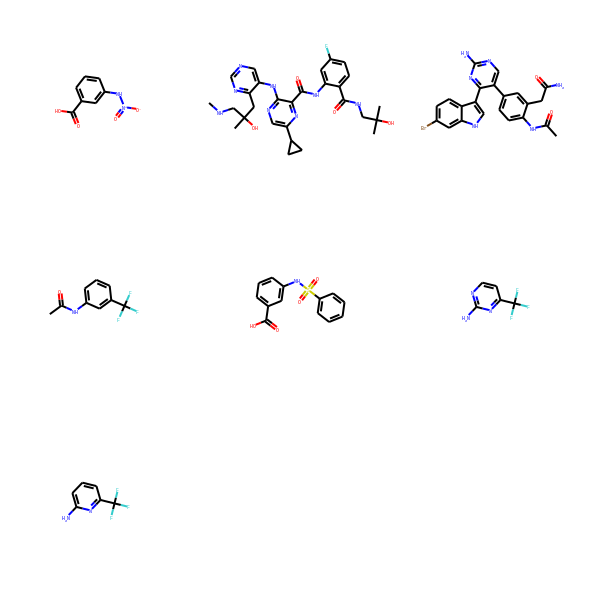

{'CC(=O)Nc1ccc(-c2cnc(N)nc2-c2c[nH]c3cc(Br)ccc23)cc1CC(N)=O',
 'CC(=O)Nc1cccc(C(F)(F)F)c1',
 'CNCC(C)(O)Cc1ncncc1Nc1ncc(C2CC2)nc1C(=O)Nc1cc(F)ccc1C(=O)NCC(C)(C)O',
 'Nc1cccc(C(F)(F)F)n1',
 'Nc1nccc(C(F)(F)F)n1',
 'O=C(O)c1cccc(NS(=O)(=O)c2ccccc2)c1',
 'O=C(O)c1cccc(N[N+](=O)[O-])c1'}

In [67]:
generate(model, ds, 10, draw=True)

CCCCCCC(=O)Nc1c(C(O)(C(F)(F)F)C(F)(F)F)ccc2ccccc12
C11cc(C)ccc(2ncCC(Ccc2(cc(F)F))(Cc(c(Occ3)(C)(C1CC
C11cc(c)ccc(NncCC(Ccc2(cc(F)F))c2c(F)=c(F)(F)(C1c2
C1c2c(c(ccc(N1CCN(OC(C(F)(F)F)C(CC(=O)ccc1ccccc11C
C1c2c(c3ccc(N)CCC(CCcC(cc(F)F)C(C)(F))cc31)CNCC1CC
C1c2c(c3ccc(N4)CC(C)(C(c)(F)c)C(CC(=O)c431)CN(C1CC
C1c2ccc3ccc(NOCCC(O)(C(cc(F)c)C(CC(F))cc31)CN(C1CC
C=C(CC)C(O)(C(F)(F)F)C(F)(F)F
C=CCCCC(=O)CCCC(CCC)C(O)(C(F)(F)F)C(F)(F)F
C=NCCNCCCCC(F)(F)C(C)(O)C(F)(F)F
CC(C)(C(F)(F)F)C(F)(F)F
CC(CCcc(-c2Nc1((C(C)(c(F)c3)F)C())(F)2)ccccccccc1Cl
CC(O)(C(F)(F)F)C(F)(F)F
CC(O)(C(F)F)C(F)(F)F
CC1cccc(-c2ccc4NC(C)3c(c)(F)C(=(F)(F)2)c1Cc1cccc(-
CC=CC(O)(C(F)(F)F)C(F)(F)F
CCC((C(NccOcc12cc(c)(((ccccc(O)((F)F)=1C(O)c1c(ccc
CCC(O)(C(F)(F)F)C(F)(F)F
CCC(OCc(ccccc1c(C(O)(C(F)(F)F)CcF)(F)F)ccO)ccccc12
CCCCCC(O)(C(F)(F)F)C(F)(F)F
CCCCCC1((C=CN(C)C(O)(ccF)(F)F)C(F)(F))c1-c1ccccc1C
CCCCCC=NCN=CCCC=C=O
CCCCCCC(=N)NCCCC(O)(C(F)(F)F)C(F)(F)F
CCCCCCC(=O)Cc(C(C(c)ccc2)(F(F)C(cc(c2)c1cc2ccccc12
CCCCCCC(=O)NC1=C(C)C=CC

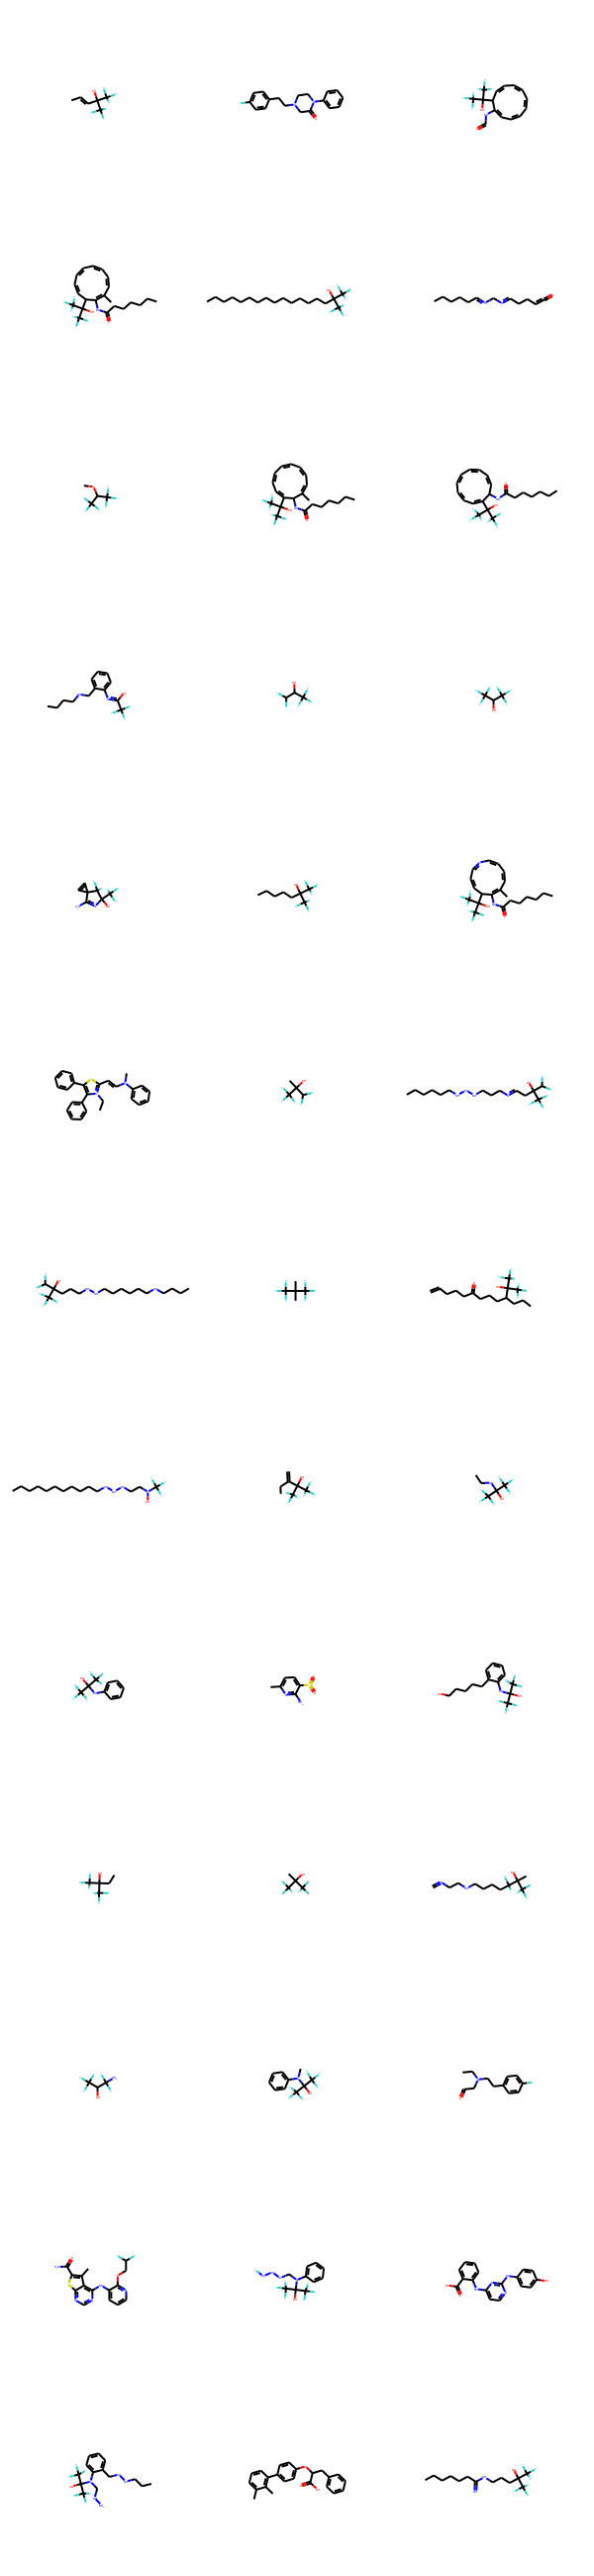

In [69]:
initial = 'CCCCCCC(=O)Nc1c(C(O)(C(F)(F)F)C(F)(F)F)ccc2ccccc12'
mutations = set()
for i in range(3):
    result = generate(model, ds, 30, smile=initial, draw=False)
    mutations.update(result)
print(initial)
print(*list(sorted(mutations)), sep='\n')
draw_smiles(mutations)


# Docking

Search space with the example inhibitor visualized:

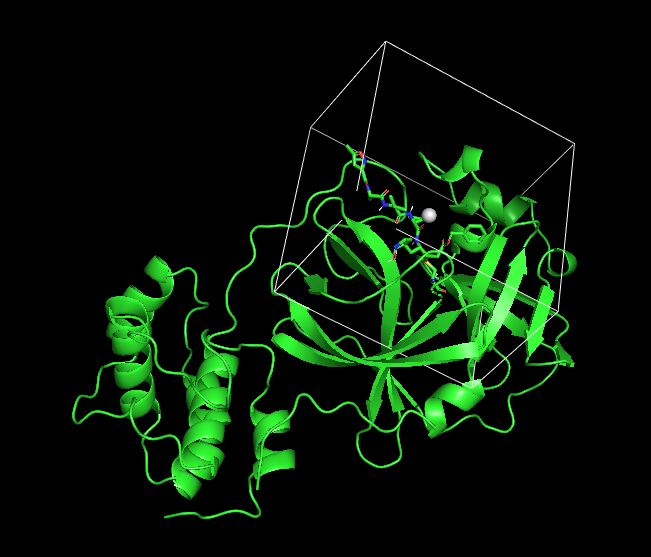

## Create a database

In [0]:
import os
from tinydb import TinyDB, Query, where
# !rm '/content/drive/My Drive/dataset/cov_db.json'
db = TinyDB('/content/drive/My Drive/dataset/cov_db.json')
def db_max(db, filter=True):
    ds = db.search(where('checked') == False)
    if not ds or not filter:
        return min(db.all(), key=lambda x: x.get('score', 0))
    return min(ds, key=lambda x: x.get('score', 0))

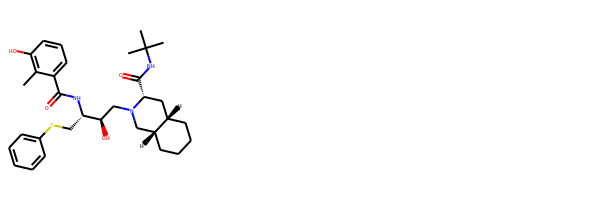

{'checked': False,
 'score': 0,
 'smile': 'Cc1c(O)cccc1C(=O)N[C@@H](CSc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]1C(=O)NC(C)(C)C'}

In [97]:
target_smile = cleaned_smile("[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC1=CC=CC=C1)NC(=O)C1=C(C)C(O)=CC=C1)[C@@H](C2)C(=O)NC(C)(C)C")
draw_smiles([target_smile])
db.upsert(dict(smile=target_smile, score=0, checked=False), where('target_smile') == target_smile)
db_max(db)

Docking cmd:

```
# Box(-10, 15, 70, 10, 15, 15)
# Box(-10, 15, 70, 10, 20, 20)
!vina --receptor cov_receptor.pdbqt --ligand cov_inhibitor.pdbqt --out cov_out.pdbqt --log ligand.log --exhaustiveness 8 --center_x -10 --center_y 15 --center_z 70 --size_x 10 --size_y 20 --size_z 20
```



{'smile': 'Cc1c(O)cccc1C(=O)N[C@@H](CSc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]1C(=O)NC(C)(C)C', 'score': 0, 'checked': True}


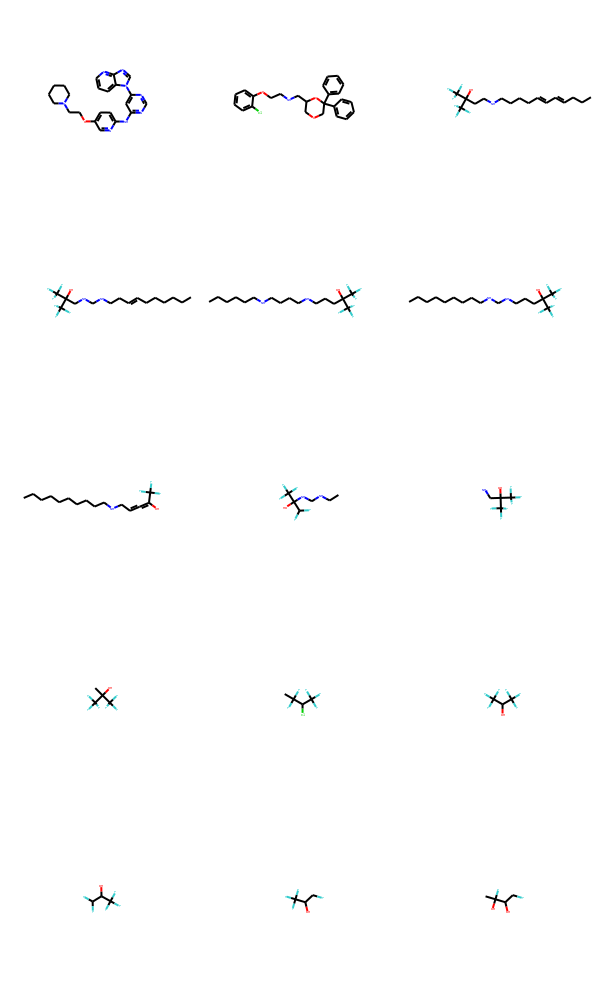

c1cnc2ncn(-c3cc(C(Cl)(c(O)(N)F)CCC)(cnF)ncn3)c2c1c1
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Detected 2 CPUs
Reading input ... done.
Setting up the scoring function ... done.
Analyzi

KeyboardInterrupt: ignored

In [103]:
while True:
    #  fetch and mark as visited
    current = db_max(db)
    print(current)
    target_smile = current['smile']
    current['checked'] = True
    db.upsert(current, where('smile') == target_smile)
    
    #  generate diverse population through mutation
    mutations = list(sorted(set(generate(model, ds, 30, smile=initial, draw=False)), key=len, reverse=True))
    draw_smiles(mutations)

    for target_smile in mutations:
        print(target_smile)

        if db.search(where('smile') == target_smile):
            print(f"duplicate {target_smile}")
            continue

        os.popen('rm inhibitor.smi').read()
        os.popen('rm inhibitor.pdbqt').read()
        
        with open('inhibitor.smi', 'w') as f:
            f.write(f"{current['smile']} derp")

        babel = os.popen('obabel inhibitor.smi -opdbqt -m --gen3d best -p -xh').read()
        if not os.path.isfile('inhibitor.pdbqt'):
            print('0 molecules converted')
            continue       

        print(os.popen('vina --receptor cov_receptor.pdbqt --ligand inhibitor.pdbqt --out cov_out.pdbqt --log ligand.log --exhaustiveness 4 --center_x -10 --center_y 15 --center_z 70 --size_x 10 --size_y 20 --size_z 20').read())

        score = 99
        with open('cov_out.pdbqt', 'r') as f:
            top = f.read(1024)
            for line in top.split('\n'):
                q = 'REMARK VINA RESULT:'
                if q in line:
                    try:
                        score = float(line.replace(q, '').split()[0])
                    except:
                        pass
        print("score", score)
        db.upsert(dict(smile=target_smile, score=score, checked=False), where('smile') == target_smile)    

# best result

In [117]:
best = db_max(db, filter=False)
print(best)

{'smile': 'c1cnN2ncn(-O3cc(C(O)(C(F)(F)F)C(=)(F)F)ncnnnc2ccc1', 'score': -4.5, 'checked': False}
